In [1]:
import numpy as np
from radial_constrained_cluster_copy import *
import matplotlib.pyplot as plt
import matplotlib
import random
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import xarray as xr
from eofs.multivariate.standard import MultivariateEof
from shapely.geometry import mapping
from sklearn.cluster import KMeans
from scipy import signal
from obspy.signal.tf_misfit import cwt
import pymannkendall as mk
from reportlab.pdfgen import canvas
from datetime import datetime
from io import BytesIO
from reportlab.lib.utils import ImageReader
from reportlab.lib.units import inch, cm
from reportlab.graphics import renderPDF
from svglib.svglib import svg2rlg
import dask
import time
import sys
import os
import threading
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

dask.config.set(scheduler="synchronous")



In [2]:
class Spinner:
    busy = False
    delay = 0.1

    @staticmethod
    def spinning_cursor():
        while 1: 
            for cursor in '|/-\\': yield cursor

    def __init__(self, delay=None):
        self.spinner_generator = self.spinning_cursor()
        if delay and float(delay): self.delay = delay

    def spinner_task(self):
        while self.busy:
            sys.stdout.write(next(self.spinner_generator))
            sys.stdout.flush()
            time.sleep(self.delay)
            sys.stdout.write('\b')
            sys.stdout.flush()

    def __enter__(self):
        self.busy = True
        threading.Thread(target=self.spinner_task).start()

    def __exit__(self, exception, value, tb):
        self.busy = False
        time.sleep(self.delay)
        if exception is not None:
            return False

In [3]:
class Report(object):

    def __init__(self, report_name, first_line, line_width, margin):
        
        self.report = canvas.Canvas(f"{report_name}.pdf")
        self.last_line = first_line
        self.first_line = first_line
        self.line_width = line_width
        self.margin = margin


    def add_header(self):

        supp = self.line_width
        self.line_width = 15
        self.add_line("Report for radially constrained cluster",9)
        self.add_line("Author: Jacopo Grassi",9)
        self.add_line(f"Created {datetime.now()}",9)
        self.line_width = supp
        self.last_line = self.last_line - 30


    def add_line(self, text, font_size):

        self.report.setFont('Helvetica', font_size)
        self.report.drawString(self.margin,self.last_line,text)
        self.last_line = self.last_line-self.line_width


    def save(self):

        self.report.save()    


In [4]:
def detrend(dataset, variable, dimension, deg):
    
    p = dataset.tp.polyfit(dim=dimension, deg=deg)
    fit = xr.polyval(dataset.tp[dimension], p.polyfit_coefficients)
    detrended = getattr(dataset,variable)-fit
    detrended = xr.DataArray(detrended).rename(variable)
    dataset = dataset.drop(variable)
    dataset = xr.merge([dataset,detrended])
    
    return dataset



def import_singledataset(dataset_path, lat_boundaries, lon_boundaries, lat_name, lon_name, time_boundaries = None):


    # Importing the dataset
    dataset = xr.open_mfdataset(dataset_path, chunks='auto', parallel=True)


    # Standardizing lat lon names
    if lat_name != 'lat':        
        dataset.rename(lat_name = 'lat')

    if lon_name != 'lon':       
        dataset.rename(lon_name = 'lon')

    # Standardizing lat lon sorting
    dataset = dataset.sortby(['lat']).sortby(['lon'])

    # Cutting space domain
    dataset = dataset.sel(lat=slice(np.min(lat_boundaries),np.max(lat_boundaries)), lon=slice(np.min(lon_boundaries),np.max(lon_boundaries)))

    # Cutting time domain (if None keeping original)
    if time_boundaries != None:
        dataset.sel(time=slice(time_boundaries[0], time_boundaries[1]))

    return dataset




def import_multipledataset(dataset_paths):

    d = []

    for i in range(len(dataset_paths)):
        
        d.append(import_singledataset)

    dataset = xr.concat(d,'time')

    return dataset
    


In [5]:
lat_boundaries = [5,40]
lon_boundaries = [65,100]


n_eof_comp = 3
do_detrend = False
space_elbow = True
fields = ['tp']

# Data importation

In [6]:
#os.chdir('Report/')

report_name = 'PROVE'
dataset_name = 'EC-EARTH History + SSP585'

report = Report(report_name, 800, 20, 50)
report.add_header()


print('Importing dataset: ', end="")
with Spinner():

    dataset = import_singledataset("~/work/jacopo/DATA/ERA5_prec_day_INDIA.nc", lat_boundaries, lon_boundaries, 'lat', 'lon', time_boundaries = None)
    dataset = dataset.load()

print('\b', 'Done')

#"/work/datasets/obs/ERA5/total_precipitation/day/ERA5_total_precipitation_day_0.25x0.25_sfc_1950-2020.nc"
#"~/work/jacopo/DATA/APHRODITE_1951_2007_daily_INDIA.nc"
#"/archive/paolo/cmip6/CMIP6/model-output/EC-Earth-Consortium/EC-Earth3/historical/atmos/day/r1i1p1f1/pr/*.nc"
#"/home/paolo/archive/cmip6/CMIP6/model-output/EC-Earth-Consortium/EC-Earth3/ssp585/atmos/day/r1i1p1f1/pr/*.nc"


lat_boundaries = [float(dataset.lat[0]),float(dataset.lat[-1])]
lon_boundaries = [float(dataset.lon[0]),float(dataset.lon[-1])]

report.add_line("Dataset specifications",12)

report.add_line(f"Dataset name: {dataset_name}",11)
report.add_line(f"Latitude boundaries: {np.min(lat_boundaries)} - {np.max(lat_boundaries)} ---- Resolution: {np.abs(float(dataset.lat[0]-dataset.lat[1]))}",11)
report.add_line(f"Longitude boundaries: {np.min(lon_boundaries)} - {np.max(lon_boundaries)} ---- Resolution: {np.abs(float(dataset.lon[0]-dataset.lon[1]))}",11)
report.add_line(f"Time boundaries: {int(dataset.time[0]['time.year'])} - {int(dataset.time[-1]['time.year'])}", 11)

report.save()

Importing dataset: Done


In [35]:
a = dir(dataset)

forbidden = ['time_bnds','lat_bnds','lon_bnds']

for i in range(len(a)):
    for j in range(len(forbidden)):
        if a[i] == forbidden[j]:
            dataset = dataset.drop(forbidden[j])

dataset

<xarray.Dataset>
Dimensions:  (time: 25871, lon: 141, lat: 141)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T15:00:00 ... 2020-12-31T11:30:00
  * lon      (lon) float64 65.0 65.25 65.5 65.75 66.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float64 5.0 5.25 5.5 5.75 6.0 ... 39.0 39.25 39.5 39.75 40.0
Data variables:
    tp       (time, lat, lon) float32 6.471e-05 7.61e-05 5.621e-05 ... 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    Conventions:  CF-1.6
    history:      Thu Jun 16 12:49:56 2022: cdo sellonlatbox,65,100,5,40 /wor...
    institution:  European Centre for Medium-Range Weather Forecasts
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...

# Region selection

In [8]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
region_division = world

himalaya = Polygon([(78, 25), (93, 25), (93, 32), (78, 32)])
himalaya = gpd.GeoDataFrame({'geometry': [Polygon([(78, 25), (93, 25), (93, 32), (78, 32)])]})
hkk = Polygon([(71, 32), (78, 32), (78, 37), (71, 37)])
hkk = gpd.GeoDataFrame({'geometry': [Polygon([(71, 32), (78, 32), (78, 37), (71, 37)])]})

## Spatial clustering

In [25]:
if do_detrend == True:
        dataset = detrend(dataset, 'tp', 'time', 1)

dataset_doy = dataset.groupby('time.dayofyear').mean().rename(dayofyear = 'time')
dataset_doy = dataset_doy.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
dataset_doy = dataset_doy.rio.write_crs("epsg:4326", inplace=True)
dataset_doy = dataset_doy.rio.clip(region_division.geometry.apply(mapping), region_division.crs, drop=False)
dataset_doy = dataset_doy.fillna(1)

to_eof = []
for i in fields:
    supp = getattr(dataset_doy,i)
    supp = supp/supp.max('time')
    to_eof.append(supp.to_numpy())
 

to_fit = to_eof

old_shape = np.shape(to_fit)
new_shape = [np.size(to_fit, axis = 0)*np.size(to_fit, axis = 1), np.size(to_fit, axis = 2)*np.size(to_fit, axis = 3)]
to_fit = np.reshape(to_fit, new_shape)
#to_fit[np.isnan(to_fit)] = 1

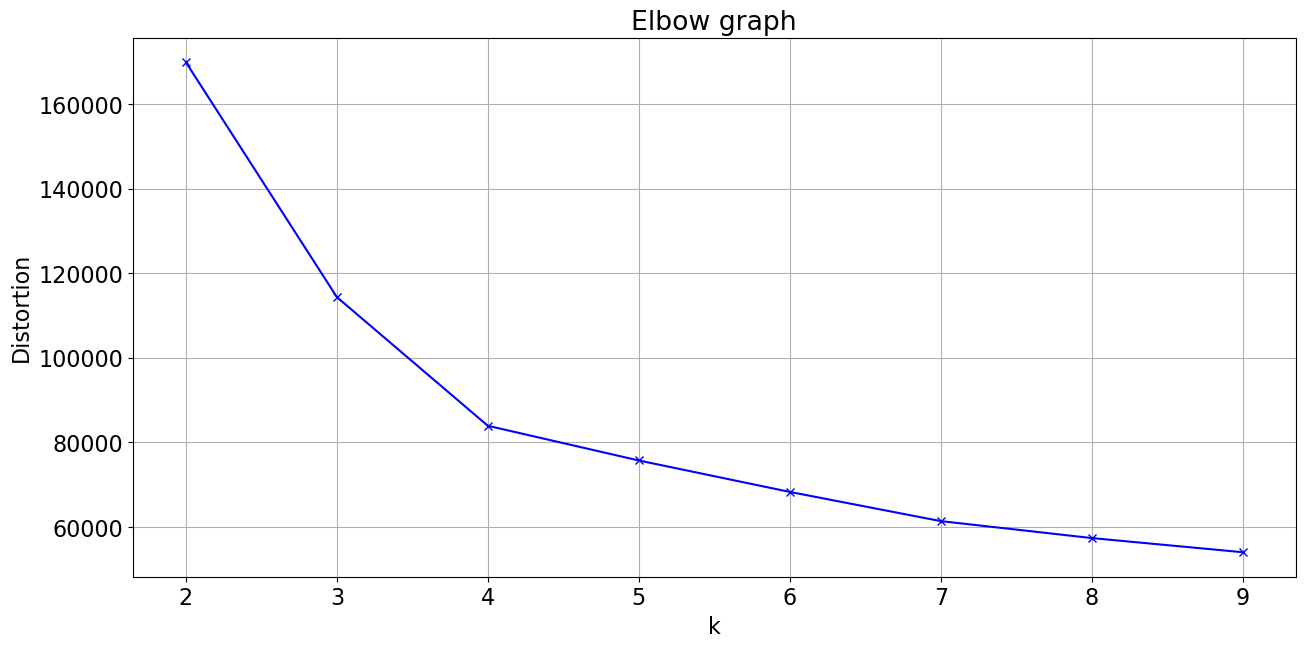

In [26]:
report.setFont('Helvetica', 12)
report.drawString(50,600,"Spatial clustering")

report.setFont('Helvetica', 10)
report.drawString(50,580,f"Number of EOF's component: {n_eof_comp}")


to_fit = np.transpose(to_fit)

if space_elbow == True:
    

    distortions = []
    K = range(2,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(to_fit)
        distortions.append(kmeanModel.inertia_)

    plt.figure(figsize=(15,7))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow graph')
    plt.grid()

    imgdata = BytesIO()
    plt.savefig(imgdata, format='png')
    imgdata.seek(0)  # rewind the data
    imgdata=ImageReader(imgdata)

    report.drawImage(imgdata,50,340,width=500,height=200)


In [ ]:
n_reg = 3
    
report.drawString(50,560,f"Number of regions: {n_reg}")

model = KMeans(n_clusters=n_reg, max_iter=300, random_state=1).fit(to_fit)
prediction = model.predict(to_fit)
pred = np.reshape(prediction,[old_shape[2], old_shape[3]])
pred =  pred.astype(float)
pred = xr.DataArray(pred).rename('pred').rename(dim_0='lat', dim_1='lon')

dataset = xr.merge([pred,dataset], compat='override')


plt.figure(figsize = (10,10))

base = world.boundary.plot(figsize=(10,10), color = 'k')
axs = dataset.pred.plot(ax = base)
region_division.boundary.plot(ax = base, color = 'r', linewidth=1, label = 'States boundaries')
himalaya.boundary.plot(ax = base, color = 'b', linewidth=2, label = 'Himalaya')
hkk.boundary.plot(ax = base, color = 'g', linewidth=2, label = 'HKK')

plt.xlim([np.min(lon_boundaries), np.max(lon_boundaries)])
plt.ylim([np.min(lat_boundaries), np.max(lat_boundaries)])
plt.title('Region clustering')
plt.xlabel('Longitude [°E]')
plt.ylabel('Latitude [°N]')
plt.legend()
plt.grid()

imgdata = BytesIO()
plt.savefig(imgdata, format='png')
imgdata.seek(0)  # rewind the data
imgdata=ImageReader(imgdata)

report.drawImage(imgdata,150,40,width=300,height=300)

report.showPage()

In [ ]:
report.setFont('Helvetica', 12)
report.drawString(50,800,"Seasonal analysis")

to_see = 2

if to_see == 'him':
    data = dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    data = data.rio.write_crs("epsg:4326", inplace=True)
    data = data.rio.clip(himalaya.geometry.apply(mapping), himalaya.crs, drop=False)
    data_doy = data.groupby('time.dayofyear').mean()
    
elif to_see == 'hkk': 
    data = dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    data = data.rio.write_crs("epsg:4326", inplace=True)
    data = data.rio.clip(hkk.geometry.apply(mapping), hkk.crs, drop=False)
    data_doy = data.groupby('time.dayofyear').mean()
    
else:
    data = dataset.where(dataset.pred == to_see)
    data_doy = dataset_doy.where(dataset.pred == to_see)
    
report.setFont('Helvetica', 10)
report.drawString(50,780,f"Region {to_see}")
    
    
fig, axs = plt.subplots(1,2, figsize = (18,6), sharey = False)
data.tp.mean(['lat','lon']).plot(ax=axs[0])
axs[0].set_title(f'Time serie precipitation over region {to_see}')
axs[0].grid()
axs[0].set_ylabel('Total precipitation [mm/day]')
axs[0].set_xlabel('Year')

data_doy.tp.mean(['lat','lon']).plot(ax=axs[1])
axs[1].set_title(f'Annual rainfall cycle over region {to_see}')
axs[1].set_xticks([0,31,60,91,121,152,182,213,244,274,305,335,366],['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan'])
axs[1].set_xlabel('Julian day')
axs[1].grid()

imgdata = BytesIO()
fig.savefig(imgdata, format='png')
imgdata.seek(0)  # rewind the data
imgdata=ImageReader(imgdata)

report.drawImage(imgdata,40,560,width=550,height=200)

In [ ]:
to_eof = []
for i in fields:
    supp = getattr(data_doy,i)
    supp = (supp-supp.mean())/supp.std()
    to_eof.append(supp.to_numpy())

solver = MultivariateEof(to_eof)
pc = solver.pcs(npcs = n_eof_comp)

fig, axs = plt.subplots(3,1, figsize = (18,15), sharex = True, sharey=True)
axs[0].plot(pc[:,0])
axs[0].set_title('Principal components of annual cycle')
axs[0].grid()
axs[0].set_ylabel('PC 1')

axs[1].plot(pc[:,1])
axs[1].set_ylabel('PC 2')
axs[1].grid()

axs[2].plot(pc[:,2])
axs[2].set_xlabel('Julian day')
axs[2].set_ylabel('PC 3')
axs[2].grid()

fig, axs = plt.subplots(1,2, figsize = (15,7), sharey = True, sharex=True)
axs[0].scatter(pc[:,0],pc[:,1])
axs[0].grid()
axs[0].set_xlabel('PC 1')
axs[0].set_ylabel('PC 2')

axs[1].scatter(pc[:,0],pc[:,2])
axs[1].grid()
axs[1].set_xlabel('PC 1')
axs[1].set_ylabel('PC 3')

# Radially constrained clustering

Radially constrained clustering is developed on the definition on cluster breakpoints instead of cluster centroids

### Algorthm improvement
Some improvement have been added to the original algorithm. The leraning rate can be changed, and a scheduler has been added to improve the convergence of the model. Also, it is possible to select a minimum length of the resulting season. 

In [ ]:
len_consistancy_check = False
min_len = 10

learning_rate = 1
scheduling_factor = 1.1
l_r_scheduler = False

n_iter = 2000

### Elbow graph


In [ ]:
err = []
g = np.arange(1,15,1)
for i in g:

    model = Radially_Constrained_Cluster(pc, i, n_iter, 
                                learning_rate, l_r_scheduler, scheduling_factor, 
                                len_consistancy_check, 1)

    model.fit()
    prediction = model.get_prediction()

    err.append(model.get_final_error())

plt.figure(figsize=(18,8))
plt.plot(g,err, '*--')
plt.grid()
plt.xlabel('N° clusters')
plt.ylabel('Within-Cluster Sum of Square')
plt.title('Elbow graph')

imgdata = BytesIO()
plt.savefig(imgdata, format='png')
imgdata.seek(0)  # rewind the data
imgdata=ImageReader(imgdata)

report.drawImage(imgdata,50,340,width=500,height=200)

### Season clustering

In [ ]:
n_seas = 4

report.drawString(50,320,f"Number of seasons {n_seas}")

model = Radially_Constrained_Cluster(pc, n_seas, n_iter, 
                                learning_rate, l_r_scheduler, scheduling_factor, 
                                len_consistancy_check, min_len)

model.fit()
prediction = model.get_prediction()


plt.figure(figsize = (15,6))
plt.plot(model.error_story)
plt.grid()
plt.xlabel('N° iterations')
plt.ylabel('Within-Cluster Sum of Square')

cc = model.get_centroids()
print(f'Final error: {model.get_final_error()}')
print(f'Breakpoints: {model.breakpoints}')

fig, ax = plt.subplots(figsize = (15,6))
scatter = ax.scatter(range(np.size(pc, axis=0)), data_doy.tp.mean(['lat','lon']), c = prediction)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Seasons")
ax.set_title('Seasonal clustering')
ax.add_artist(legend1)
ax.grid()
ax.set_xlabel('julian day')
ax.set_ylabel('Tp [mm/day]')
ax.set_xticks([0,31,60,91,121,152,182,213,244,274,305,335,366],['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan'])

imgdata = BytesIO()
plt.savefig(imgdata, format='png')
imgdata.seek(0)  # rewind the data
imgdata=ImageReader(imgdata)

report.drawImage(imgdata,50,100,width=500,height=200)

fig, axs = plt.subplots(1,2, figsize = (18,6), sharey = True, sharex=True)
axs[0].scatter(pc[:,0],pc[:,1], c = prediction )
for i in range(n_seas):
    axs[0].scatter(cc[i][0],cc[i][1], s = 200)
    axs[0].scatter(cc[i][0],cc[i][1], s = 200)
axs[0].grid()
axs[0].set_xlabel('PC 1')
axs[0].set_ylabel('PC 2')

axs[1].scatter(pc[:,0],pc[:,2], c = prediction)
axs[1].grid()
axs[1].set_xlabel('PC 1')
axs[1].set_ylabel('PC 3')

report.showPage()

## Application 1 - Defining breakpoints over all period and study interannual trends

In [ ]:
year =  np.unique(data.time['time.year'].to_numpy())
n_year = len(np.unique(data.time['time.year'].to_numpy()))

serie = data.tp.mean(['lat','lon']).to_numpy()
time = pd.DatetimeIndex(data.time.to_numpy())
line_time = pd.Series(serie, index=time)

breakpoints = np.sort(model.breakpoints)

season_mean = np.empty((n_seas,n_year))
season_mean[:] = np.nan 

for i in range(n_seas):
    
    if i == n_seas - 1:
        start = np.squeeze(np.where(line_time.index.dayofyear == breakpoints[i]))
        end = np.squeeze(np.where(line_time.index.dayofyear == breakpoints[0]))
        
        start = np.delete(start,-1)
        end = np.delete(end,0)
        
    else:    
        start = np.squeeze(np.where(line_time.index.dayofyear == breakpoints[i]))
        end = np.squeeze(np.where(line_time.index.dayofyear == breakpoints[i+1]))

    for j in range(len(start)-1):
        
        season = np.arange(start[j],end[j],1)
        season_mean[i,j] = np.mean(serie[season])
    
colors = ['red','blue','green','purple']

    
plt.figure(figsize=(15,7))

for i in range(n_seas):
    x = year
    y = season_mean[i]
    
    idx = np.isfinite(x) & np.isfinite(y)
    ab = np.polyfit(x[idx], y[idx], 1)
    
    if i == n_seas-1:
        
        plt.plot(x, ab[1]+x*ab[0], c = colors[0])
        plt.plot(year,season_mean[i], '-.*', label = f'season {0}', c = colors[0], markersize = 15)
        result = mk.original_test(season_mean[i])
        print(f'Season {0}')
        print(f'Linear trend: {ab[0]}')
        print(f'Mann Kendall trend: {result.slope} - {result.h} - {result.p}')
        
    else:
    
        plt.plot(x, ab[1]+x*ab[0], c = colors[i+1])
        plt.plot(year,season_mean[i], '-.*', label = f'season {i+1}', c = colors[i+1], markersize = 15)
        result = mk.original_test(season_mean[i])
        print(f'Season {i+1}')
        print(f'Linear trend: {ab[0]}')
        print(f'Mann Kendall trend: {result.slope} - {result.h} - {result.p}')
    
plt.xlabel('year')
plt.ylabel('mean precipitation [mm/day]')
plt.grid()
plt.legend()

## Application 2 - Splitting in periods and study evolution of breakpoints

In [ ]:
periods = np.arange(year[0],year[-2],1)
step = 15

b_p = []
t_p = []

for i in np.arange(0,len(periods)-step,1):
    
    to_analyze = data.sel(time = slice(str(periods[i]),str(periods[i+step])))
    to_analyze = to_analyze.groupby('time.dayofyear').mean()
     
    to_eof = []
    for i in fields:
        supp = getattr(to_analyze,i)
        supp = (supp-supp.mean())/supp.std()
        to_eof.append(supp.to_numpy())

    solver = MultivariateEof(to_eof)
    pc = solver.pcs(npcs = n_eof_comp)

    model = Radially_Constrained_Cluster(pc, n_seas, n_iter, 
                                learning_rate, l_r_scheduler, scheduling_factor, 
                                len_consistancy_check, min_len)
    model.fit()
    prediction = model.get_prediction()
    prediction = np.squeeze(np.int32(prediction))

    b_p.append(model.breakpoints)
    
    season_mean = np.empty((n_seas,1))
    season_mean[:] = np.nan
    tr = to_analyze.tp.mean(['lon','lat']).to_numpy()

    
    for j in range(n_seas):
             
        gr = tr[prediction == j]
        season_mean[j] = np.mean(gr)
        
    t_p.append(season_mean)


b_p = np.array(b_p)
b_p = np.transpose(b_p)

t_p = np.array(t_p)
t_p = np.squeeze(t_p)
t_p = np.transpose(t_p)

In [ ]:
report.setFont('Helvetica', 10)
report.drawString(50,800,f"Step for rolling mean {step}")

colors = ['red','blue','green','purple']

plt.figure(figsize=(15,7))

print()
print('BREAKPOINTS TRENDS')

b_p_sig = []

for i in range(n_seas):
    x = periods[0:-step]
    y = b_p[i]
    
    idx = np.isfinite(x) & np.isfinite(y)
    ab = np.polyfit(x[idx], y[idx], 1)
    
    if i == n_seas-1:
        
        plt.plot(x, ab[1]+x*ab[0], c = colors[0])
        plt.plot(periods[0:-step],b_p[i], '-.*', label = f'season {0}', c = colors[0], markersize = 15)
        result = mk.original_test(b_p[i])
        print(f'Season {0}')
        print(f'Linear trend: {ab[0]}')
        print(f'Mann Kendall trend: {result.slope} - {result.h} - {result.p}')
        b_p_sig.append([f'season {0} - {result.h} - sign {np.sign(result.slope)}'])
        
    else:
    
        plt.plot(x, ab[1]+x*ab[0], c = colors[i+1])
        plt.plot(periods[0:-step],b_p[i], '-.*', label = f'season {i+1}', c = colors[i+1], markersize = 15)
        result = mk.original_test(b_p[i])
        print(f'Season {i+1}')
        print(f'Linear trend: {ab[0]}')
        print(f'Mann Kendall trend: {result.slope} - {result.h} - {result.p}')
        b_p_sig.append([f'season {i+1} - {result.h} - sign {np.sign(result.slope)}'])
    
plt.xlabel('year')
plt.ylabel('season breakpoint [julian day]')
plt.yticks([0,31,60,91,121,152,182,213,244,274,305,335,366],['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan'])
plt.grid()
plt.legend()
plt.title('Breakpoints evolution')

imgdata = BytesIO()
plt.savefig(imgdata, format='png')
imgdata.seek(0)  # rewind the data
imgdata=ImageReader(imgdata)

report.drawImage(imgdata,40,580,width=550,height=200)

plt.figure(figsize=(15,7))

print()

print('TOTAL PRECIPITATIONS TRENDS')
t_p_sig = []

for i in range(n_seas):
    x = periods[0:-step]
    y = t_p[i]
    
    idx = np.isfinite(x) & np.isfinite(y)
    ab = np.polyfit(x[idx], y[idx], 1)
    

    plt.plot(x, ab[1]+x*ab[0], c = colors[i])
    plt.plot(periods[0:-step],t_p[i], '-.*', label = f'season {i}', c = colors[i], markersize = 15)
    result = mk.original_test(t_p[i])
    print(f'Season {i+1}')
    print(f'Linear trend: {ab[0]}')
    print(f'Mann Kendall trend: {result.slope} - {result.h} - {result.p}')
    t_p_sig.append([f'season {i} - {result.h} - sign {np.sign(result.slope)}'])
    
plt.xlabel('year')
plt.ylabel('t_p[mm/day]')
plt.grid()
plt.legend()
plt.title('Total precipitation evolution')

imgdata = BytesIO()
plt.savefig(imgdata, format='png')
imgdata.seek(0)  # rewind the data
imgdata=ImageReader(imgdata)

report.drawImage(imgdata,40,360,width=550,height=200)

report.drawString(50,300,f"Mann-Kendall for brakpoints trends:")
report.drawString(50,280,f"{b_p_sig}")

report.drawString(50,220,f"Mann-Kendall for total precipitations trends:")
report.drawString(50,200,f"{t_p_sig}")

report.save()

### Addendum: ensemble run mode

In order to improve the stability of the model and avoid the local monima problem, an ensemble mode is developed. The single mode algorithm is performed n_ensemble times, stochastically varying the hyperparameter in a range +- selected value/s_factor. At the end, the average of all found breakpoints is computed and used as final result. 

In [ ]:
#model = Radially_Constrained_Cluster(pc, n_seas, n_iter, 
                                #learning_rate, l_r_scheduler, scheduling_factor, 
                                #len_consistancy_check, min_len, 'ensemble_stochastic', 20, s_factor = 10000)


#model.fit()
#prediction = model.get_prediction()


#print(f'Final error: {model.get_final_error()}')
#print(f'Breakpoints: {model.breakpoints}')


#plt.figure(figsize = (15,6))
#plt.scatter(range(np.size(pc, axis=0)), data_doy.tp.mean(['lat','lon']), c = prediction)
#plt.grid()

#fig, axs = plt.subplots(1,2, figsize = (18,6), sharey = True, sharex=True)
#axs[0].scatter(pc[:,0],pc[:,1], c = prediction )
#axs[0].grid()
#axs[0].set_xlabel('PC 1')
#axs[0].set_ylabel('PC 2')

#axs[1].scatter(pc[:,0],pc[:,2], c = prediction)
#axs[1].grid()
#axs[1].set_xlabel('PC 1')
#axs[1].set_ylabel('PC 3')

In [ ]:
#to_eof = []
#for i in fields:
#    supp = getattr(data,i)
#    supp = (supp-supp.mean())/supp.std()
#    to_eof.append(supp.to_numpy())

#solver = MultivariateEof(to_eof)
#pc = solver.pcs(npcs = n_eof_comp)

#for i in range(n_eof_comp):

#    to_cwt = pc[:,i]

#    t, dt = np.linspace(0, 71, len(to_cwt), retstep=True)
#    fs = 1/dt
#    w = 8.
#    freq = np.linspace(1, 5, 100)
#    widths = w*fs / (2*freq*np.pi)
#    cwtm = signal.cwt(to_cwt, signal.morlet2, widths, w=w)


#    fig = plt.figure(figsize=(15, 6))
#    im  = plt.pcolormesh(t, freq, np.abs(cwtm), cmap='jet', shading='gouraud')
#    plt.ylabel('F [yr^-1]')
#    plt.xlabel('Time [yr since 1950]')
#    plt.grid()
#    plt.title(f'PC {i+1}')